<a href="https://colab.research.google.com/github/jonbaer/googlecolab/blob/master/Diffgram_Streaming_data_to_Pytorch_Tuturial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Streaming Data to Pytorch Using Diffgram SDK



In this notebook you will see a full example on how to stream a big dataset (100k+) images into your training model without having to load the entire data on your local machine. We will use the Pytorch Fast RCNN network used in this  blog post by [Maximilian Beckers]( https://towardsdatascience.com/building-your-own-object-detector-pytorch-vs-tensorflow-and-how-to-even-get-started-1d314691d4ae). *This notebook is focused on pytorch, but the same concepts work for [tensorflow too](https://diffgram.readme.io/docs/sdk-dataset-to_tensorflow).*

## About the data
We will be using the COCO Dataset publicly available on: 

1. Visit the dataset: https://diffgram.com/studio/annotate/coco-dataset.
2. Click the "**Dataset Explorer**" tab see more examples of the data.

## Start with Installing the SDK
Ok, now let's start by installing the Diffgram SDK:


In [ ]:
!pip install diffgram==0.4.13

     |████████████████████████████████| 42 kB 613 kB/s 


## Now we will get the example Project 

In [ ]:
from diffgram import Project

coco_project = Project(project_string_id='coco-dataset') 

As you can see on: https://diffgram.com/studio/annotate/coco-dataset.

All the images are contained in the "Default" dataset, and the dataset contains a total of 111852 images with bounding boxes on each of them.

With Diffgram you can fetch the dataset without loading the entire 100,000+, files and labelsthey
will be loaded only until you really want to feed them into the model.

## Exploring the dataset - Stream an element

In [ ]:
# Get the dataset
default_dataset = coco_project.directory.get(name = 'Default')

# Let's see how many images we got
print('Number of items in dataset: {}'.format(len(default_dataset)))

# Let's stream just the 8th element of the dataset
print('8th element: {}'.format(default_dataset[7]))



Number of items in dataset: 111851
8th element: {'image': Array([[[  0,   3,   0],
        [  0,   3,   0],
        [  0,   2,   0],
        ...,
        [ 87, 103, 100],
        [ 87, 103, 100],
        [ 87, 103, 100]],

       [[  0,   2,   0],
        [  0,   2,   0],
        [  0,   2,   0],
        ...,
        [ 89, 105, 102],
        [ 89, 105, 102],
        [ 89, 105, 102]],

       [[  0,   2,   0],
        [  0,   2,   0],
        [  0,   1,   0],
        ...,
        [ 92, 108, 105],
        [ 91, 107, 104],
        [ 91, 107, 104]],

       ...,

       [[ 19,  22,  29],
        [ 23,  26,  33],
        [ 23,  26,  33],
        ...,
        [ 45,  62,  70],
        [ 33,  50,  58],
        [ 92, 109, 116]],

       [[  7,  10,  17],
        [  7,  10,  17],
        [  9,  12,  19],
        ...,
        [ 67,  84,  91],
        [ 56,  73,  80],
        [ 69,  86,  93]],

       [[  7,  10,  17],
        [  7,  10,  17],
        [  9,  12,  19],
        ...,
        [ 76,  9

# Adding Pytorch and setting up the Model

To setup and traing our model we will leverage the pretrained models
that pytorch visions module offers. We'll use a faster R-CNN model for this tutorial.

Let's start by clonding the vision module and copying some useful files for the tutorial.

In [ ]:
%%bash
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0
cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
import pycocotools
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import torchvision
from PIL import ImageDraw


# Transforming your dataset to PyTorch dataset using Diffgram SDK

Now that we have all our libraries imported we just need our pytorch dataset. We can get this pretty easily by doing: 

In [ ]:
pytorch_ready_dataset = default_dataset.to_pytorch()

**Now you have a fully working pytorch dataset! Wow!** 

Depending on the model needs, you might need to transform the data, change the order of coordinates, etc. 

Ok for this Example we will need a shape similar to this one:


In [ ]:
"""
Example of a training data sample: a Tupple where first elm is the image and second elm is a dict with the label data.

(<PIL.Image.Image image mode=RGB size=650x417 at 0x7FE20F358908>,  
 {'area': tensor([141120.]),
 'boxes': tensor([[ 81.,  88., 522., 408.]]),   
 'image_id': tensor([0]),   
 'iscrowd': tensor([0]),   
 'labels': tensor([1])}
 )
 """

"\nExample of a training data sample: a Tupple where first elm is the image and second elm is a dict with the label data.\n\n(<PIL.Image.Image image mode=RGB size=650x417 at 0x7FE20F358908>,  \n {'area': tensor([141120.]),\n 'boxes': tensor([[ 81.,  88., 522., 408.]]),   \n 'image_id': tensor([0]),   \n 'iscrowd': tensor([0]),   \n 'labels': tensor([1])}\n )\n "

Let's write a couple pytorch Transform objects, to change the sample a bit to be adjusted for our faster R-CNN model.

In [ ]:
class AdjustForRCNN:
    """
      Adjust a sample from the Diffgram SDK generated pytorch
      Dataset to be used for the RCNN model.

    """

    def __call__(self, sample):
        result = []
        image = sample['image']
        image_id = torch.tensor([sample['diffgram_file'].id])
        project = sample['diffgram_file'].client
        project.get_label_file_dict(use_session = False)
        label_id_name_map = coco_project.name_to_file_id
        label_id_list = [val for k, val in label_id_name_map.items()]
        result.append(image)
        boxes_array = []
        for i in range(len(sample['x_min_list'])):
            # Let's build the box array with the shape
            # [x_min,y_min,x_max, y_max]
            boxes_array.append([
                sample['x_min_list'][i],
                sample['y_min_list'][i],
                sample['x_max_list'][i],
                sample['y_max_list'][i],
            ])
        boxes = torch.as_tensor(boxes_array, dtype = torch.float32)
        num_objs = len(boxes_array)
        labels_list = sample['label_id_list']
        label_numbers_list = [label_id_list.index(x) for x in labels_list]
        labels = torch.as_tensor(label_numbers_list, dtype = torch.int64)
        if num_objs > 0:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.as_tensor([], dtype = torch.float32)
        # suppose all instances are not crowd for this tutorial
        iscrowd = torch.zeros((num_objs,), dtype = torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        result.append(target)
        image = result[0]
        target = result[1]
        return image, target

import random
class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if len(target["boxes"]) > 0:
            return image, target
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
            if "keypoints" in target:
                keypoints = target["keypoints"]
                keypoints = _flip_coco_person_keypoints(keypoints, width)
                target["keypoints"] = keypoints
        return image, target

# For composing transforms
class ComposeTransforms(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, sample):
        image = None
        target = None
        for t in self.transforms:
            if type(sample) == dict and image is None and target is None:
                image, target = t(sample)
            else:
                image, target = t(image, target)
        return image, target


Now let's apply the transform to our dataset. It should look like the below code, but we'll still need to add a couple transforms later so we'll add the transform using pytorch's `transform.Compose():`

In [ ]:
pytorch_ready_dataset = default_dataset.to_pytorch(
    transform = T.Compose([AdjustForRCNN()])
)

# Get the pretrained model and transforms.

Let's now get the pretrained model on COCO and the transforms needed for
the model to train properly.



In [ ]:
def get_model(num_classes):
  # load an object detection model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
   
  return model

def get_transform(train):
  transforms = []
  transforms.append(AdjustForRCNN()) # Our previously created transform
  # converts the image, a PIL image, into a PyTorch Tensor
  transforms.append(T.ToTensor())
  if train:
    # during training, randomly flip the training images
    # and ground-truth for data augmentation
    transforms.append(RandomHorizontalFlip(0.5))
  return ComposeTransforms(transforms)


Let's use our new dataset and transforms now:
For the purpose of training faster and showing some results, we've sliced the complete dataset to 80 images for training and 10 for testing.

In [ ]:
dataset = default_dataset.to_pytorch(
    transform = get_transform(train=True)
)
dataset_test = default_dataset.to_pytorch(
    transform = get_transform(train=False)
)
torch.manual_seed(1)
dataset.diffgram_file_id_list = dataset.diffgram_file_id_list[0:80]
dataset_test.diffgram_file_id_list = dataset_test.diffgram_file_id_list[100:110]

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
              dataset, batch_size=2, shuffle=True, num_workers=2,
              collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(
         dataset_test, batch_size=1, shuffle=False, num_workers=2,
         collate_fn=utils.collate_fn)


In [ ]:
print("We have: {} examples, {} are training and {} testing".format(len(dataset) + len(dataset_test), len(dataset), len(dataset_test)))
# Check GPU
torch.cuda.is_available()

We have: 90 examples, 80 are training and 10 testing


True

Let's proceed now to set up our model for training. Notice how little we've done so far to manage our training data. It is all contained in our magic `default_dataset` object :)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# Get all the labels in the diffgram project
coco_project.get_label_file_dict(use_session = False)
label_id_name_map = coco_project.name_to_file_id
num_classes = len(label_id_name_map.keys())
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

# Let's train!

For training the model we'll use a simple forloop and call the `train_one_epoch` fucntion provided by pytorch.

This is what's going on on the training loop:

1. Diffgram dataset is being asked for a new item
2. Our SDK asks for the File data and boxes data on demand, to avoid RAM/Resources overloading.
3. Once the data gets loaded, our dataset object returns the full image bytes and annotations to be ingested into the model.
4. Process repeats until model is trained!

**What are the benefits?**

1. We now have a universal way to access training dataset, as long as you have the diffgram project ID and the dataset name, you can have the data.
2. No need for super big machine for training data, RAM stops becoming a problem.
3. Centralized way to access the data via the diffgram file ID's. Now we can access all the metadata related to a blob with a single unique identifier.
4. Single Source of Truth. We remove the need for exporting data to JSON or other formats (we support it if you still want it though). This allows better communication betweend ML Engineers, Data Scientists and Annotation Teams, as they all have a single source to access the data on the cloud.


In [ ]:
import os
dir_path = 'cocomodel'
if os.path.isfile(dir_path + '/model'):
  model.load_state_dict(torch.load(dir_path + '/model'))
else:
  # let's train it for 3 epochs
  num_epochs = 3

  for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

  # Save the model

  if not os.path.exists(dir_path):
      os.makedirs(dir_path)
  torch.save(model.state_dict(), dir_path + '/model')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [ 0/40]  eta: 0:06:43  lr: 0.000133  loss: 5.1725 (5.1725)  loss_classifier: 4.5744 (4.5744)  loss_box_reg: 0.4713 (0.4713)  loss_objectness: 0.0039 (0.0039)  loss_rpn_box_reg: 0.1229 (0.1229)  time: 10.0840  data: 7.5390  max mem: 3181
Epoch: [0]  [10/40]  eta: 0:02:06  lr: 0.001414  loss: 3.6162 (3.6463)  loss_classifier: 3.2755 (3.0555)  loss_box_reg: 0.5400 (0.5450)  loss_objectness: 0.0039 (0.0098)  loss_rpn_box_reg: 0.0120 (0.0360)  time: 4.2049  data: 2.3408  max mem: 3697
Epoch: [0]  [20/40]  eta: 0:01:17  lr: 0.002695  loss: 2.3386 (3.0173)  loss_classifier: 1.5147 (2.3223)  loss_box_reg: 0.5605 (0.6041)  loss_objectness: 0.0121 (0.0346)  loss_rpn_box_reg: 0.0316 (0.0563)  time: 3.5779  data: 1.8561  max mem: 3697
Epoch: [0]  [30/40]  eta: 0:00:38  lr: 0.003975  loss: 1.7600 (2.5350)  loss_classifier: 1.0675 (1.8660)  loss_box_reg: 0.5496 (0.5799)  loss_objectness: 0.0421 (0.0362)  loss_rpn_box_reg: 0.0367 (0.0528)  time: 3.6636  data: 1.9487  max mem: 3781
Epoch: 

# Make some Predictions

Now that we have the trained model, we can load samples from the diffgram created dataset and make some predictions. This is just to show an example on how to use the data streamed from Diffgram in a typical model predictions scenario.The model results and accuracy are not the main focus here since.

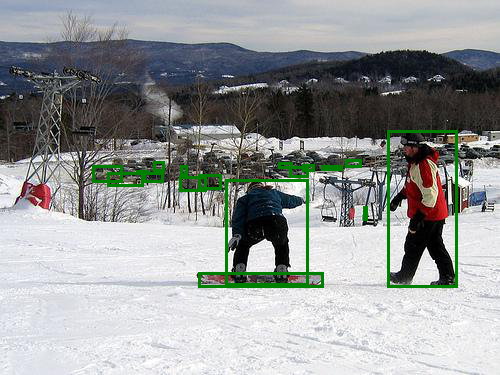

In [ ]:
loaded_model = get_model(num_classes = num_classes)
# loaded_model.load_state_dict(torch.load('diffgram_tutorial_streaming_data/pytorch object detection/cocodataset/model'))

idx = 2
img, _ = dataset_test[idx]
label_boxes = np.array(dataset_test[idx][1]["boxes"])
#put the model in evaluation mode
loaded_model.eval()
with torch.no_grad():
   prediction = loaded_model([img])
image = Image.fromarray(img.mul(255).permute(1, 2,0).byte().numpy())
draw = ImageDraw.Draw(image)
# draw groundtruth
for elem in range(len(label_boxes)):
  draw.rectangle([(label_boxes[elem][0], label_boxes[elem][1]),(label_boxes[elem][2], label_boxes[elem][3])], 
  outline ="green", width =3)

for element in range(len(prediction[0]["boxes"])):
  boxes = prediction[0]["boxes"][element].cpu().numpy()
  score = np.round(prediction[0]["scores"][element].cpu().numpy(), decimals= 4)
  print('aaa boxes', boxes, score)
  if score > 0.006:
    draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], 
    outline ="red", width =3)
    draw.text((boxes[0], boxes[1]), text = str(score))

image

# Conclusion

As you can see we were able to easily fetch, split and manipulate really big datasets without actually requiring the ram to allocate that information. This is the great advantage that streaming from the Diffgram SDK gives you, you are able to share, use, and manipulate the data from a single point and all your teammates will inmediately see any new annotations or changes added to the dataset without any file sharing or data manipulations.